# Lab 1: Python Webscraping & ETL



> In data science, to get data to actually work with, an ETL (Extract, Transform and Load) procedure is used. 

> **Extraction** means that data is collected from somewhere

> **Transform** means that the data is converted into a useable format. In this step, the data is also cleaned. Data cleaning consists of several operations such as the removal of bad data, removal of duplicate data and the resolution of missing values.

> In the **Load** step, the data is stored for future usage (such as a database).

> In this practicum we will focus on the two first steps, extracting and transforming data. Furthermore, we also will do data exploration. Later in this course you will see how machine learning can be applied to make predictions using data. To be able to do this, the data has to be understood. Hence, data exploration is required.

![ETL](http://uploads.webflow.com/54e3cc87305a0f0a0665f71f/5537351f5f1065d401cde83c_etl-elt-architecture.jpg)

> Two new libraries will be used to do these steps: *matplotlib* a python visualization library and *pandas* a data manipulation library





### The use case:
> [EVA](http://www.evavzw.be/) is a website of a vegetarian organization. On their website they have a [list of restaurants](http://www.evavzw.be/resto) from all over Belgium. We want to have this data to get insights into these restaurants. However, EVA does not have a public web API which we can query to access this information. Hence, we will use the [selenium](https://selenium-python.readthedocs.io/) webscraper to scrape the information from their site. Subsequently, we will analyse the collected data.

![ETL](https://pbs.twimg.com/profile_images/378800000338402401/9c164104f9e1d9f5c2eea49368973ce4.png)

> Fill in this notebook, "**< FILL_IN >**" gives an indication where code is expected

### Installation

> Anaconda will have installed pandas and matplotlib. However, selenium will not be installed. 

> To search for a selenium package open a shell/prompt:

>    * anaconda search -t conda selenium

> Install as follows (example package):

>    * conda install -c bokeh selenium

>    * If the above doesn't work try installing another one from the list (anaconda search) that is compatible with your OS and python 3. For Windows 10 the following worked:

>    * conda install -c  conda-forge selenium

> Additionally, selenium requires a chromedriver: https://sites.google.com/a/chromium.org/chromedriver/downloads

> Put this driver in the same folders as this notebook

**IMPORTANT:** The version of the chrome driver must match the version of your chrome installation. To check your version check the chrome menu in help - About Chrome (https://help.zenplanner.com/hc/en-us/articles/204253654-How-to-Find-Your-Internet-Browser-Version-Number-Google-Chrome) 

* * *

### Pandas

In [1]:
import pandas as pd
import numpy as np

> Pandas enables us to use DataFrames. A DataFrame is a two-dimensional potentially heterogeneous tabular data structure with labeled axes (rows and columns).

> **NOTE**: Operations on dataframes usually don't modify the original frame but create a new one, you will often use the following construction df = df.func(), the assignment is important!

In [2]:
# Generate a 2D array of random values. There are 10 rows and 4 columns
dummy_data = np.random.randint(0,100,size=(10, 4))

# The matching column headers for the 4 columns
matching_columns = ['A','B','C','D']

# Create a pandas DataFrame using the data and headers.
df = pd.DataFrame(dummy_data, columns=matching_columns)
df

,A,B,C,D
0,54,95,77,13
1,20,72,47,34
2,36,72,45,88
3,64,49,58,64
4,67,12,51,21
5,19,8,8,55
6,33,77,71,40
7,60,8,19,70
8,79,68,97,2
9,11,6,21,40


> We can select columns:

In [3]:
df.A

# alternative
df[['A']]

,A
0,54
1,20
2,36
3,64
4,67
5,19
6,33
7,60
8,79
9,11


> Or multiple columns

In [4]:
df[['A','B']]

,A,B
0,54,95
1,20,72
2,36,72
3,64,49
4,67,12
5,19,8
6,33,77
7,60,8
8,79,68
9,11,6


> A dataframe can be created from a numpy ndarray, a list of dictionaries, and many other options.
> Dataframes can be used to do many types of operations on them and also to plot the data in various ways.
> Throughout this lab you will get familier with pandas. The [pandas API documentation](http://pandas.pydata.org/pandas-docs/stable/api.html) wil be your first source of information to check when you want to know more about pandas

RECOMMENDED1:
> If you want to get to know the basics of pandas feel free to do the [10 minutes of pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)

RECOMMENDED2: 

> Pandas + Matplotlib: http://pandas.pydata.org/pandas-docs/stable/visualization.html

* * *

### 1: Get data using the selenium web scraper and put it into a pandas DataFrame

In [5]:
import time
from selenium import webdriver
import pandas as pd
import requests
import matplotlib.pylab as plt
import numpy as np
from collections import Counter
%matplotlib inline

> Using selenium, we will first create a webdriver. A webdriver will allows us to programmatically access a website.

> If a Chrome window opens, do not close it.

In [6]:
url_eva = 'http://www.evavzw.be/resto'

# If you use a mac OSX or Ubuntu/Linux OS:
#driver = webdriver.Chrome("./chromedriver")

# Windows:
driver = webdriver.Chrome("./chromedriver.exe")

In [7]:
# driver.get method will navigate to a page given by the URL
driver.get(url_eva)

> On the EVA website there is a page called resto. On this page there is a matrix structure containing the details of the restaurants.  We want to get all the info from every restaurant and put it in a DataFrame. Each column will be a property such as name, street, zipcode,... and every row will be a restaurant.

In [8]:
restaurants = []

# while testing use a small number
number_of_pages = 47

> We will loop over the pages to access all restaurants.
> In this loop we will loop over each restaurant div and extract all the information we need.
> The access the information we will use DOM elements and css class selectors.

> The available functions to scan the DOM can be found here: http://selenium-python.readthedocs.io/locating-elements.html

> In order to find these identifiers open the webpage in for example Chrome:
> * right mouse click + inspect will show you the source code (DOM)

> More info on CSS selectors: https://www.w3schools.com/cssref/css_selectors.asp



In [9]:
def check_existence(value,s):
    try:
        s.find_element_by_class_name(value)
        return True
    except:
        return False

In [10]:
number_extracted_correctly = 0
number_bad_records = 0

# Loop over the different pages
for i in range(0, number_of_pages-1):

    # In the DOM we look for the class "node-restaurant" which is associated to the restaurant divs
    selections = driver.find_elements_by_class_name('node-restaurant')

    # Loop over the divs
    for s in selections:
        # Try catch in python, to skip over the records that do not contain the info we need.
        try:
            
            # Dictionary called "o" wherein we will store the data:
            o = dict()
            
            # First we will extract the name and address of the restaurant
            # Extract the name of the restaurant
            o['name'] = s.find_element_by_tag_name("a").text
            o['street'] = s.find_element_by_class_name("street").text
            o['zipcode'] = s.find_element_by_class_name("postal").text
            o['city'] = s.find_element_by_class_name("city").text
            
            # Extract the tag information. If the tag is given to the restaurant, we will set the corresponding value
            # in the dictionary to True, else False using the check_existance function
            
            o['cateraar'] = check_existence("cateraar",s)
            o['snack'] = check_existence("snack",s)
            o['eethuis'] = check_existence("eethuis",s)
            o['veganvriendelijk'] = check_existence("veganvriendelijk",s)
            o['eva-voordeel'] = check_existence("eva-voordeel",s)
            o['approved-by-eva'] = check_existence("approved-by-eva",s)
            o['gastronomisch'] = check_existence("gastronomisch",s)
            
            # we will ignore the next two tags as they are not allowed by W3C standards!
            #o['100-vegetarisch'] = <FILL_IN>
            #o['100-plantaardig'] = <FILL_IN>
            
            # Put the restaurant dictionary in the restaurants list
            restaurants.append(o)
            
            number_extracted_correctly +=1
        except:
            number_bad_records +=1

    # Go to the next page by clicking the HIDDEN "volgende" button or other correct button.
    selection = driver.find_element_by_class_name("pager-next").find_element_by_tag_name("a")
    driver.execute_script("arguments[0].click();", selection)
        
    # 2 second delay required, else the page will not be loaded when selecting elements
    time.sleep(2)

#driver.close()

print ("Number of correctly extracted restaurant records: %i" % number_extracted_correctly)
print ("Number of bad records that were ignored: %i" % number_bad_records)

Number of correctly extracted restaurant records: 888
Number of bad records that were ignored: 32


In [11]:
# Using the created list of dictionaries, we create a Dataframe. 
# The column headers will be the dictionary keys.
df_resto = pd.DataFrame(restaurants)

### 2. Data exploration

In [12]:
# Printing the entire DataFrame would be too much. Therefore, we can use ".head(n)" to print the first n records
df_resto.head(20)

,name,street,zipcode,city,cateraar,snack,eethuis,veganvriendelijk,eva-voordeel,approved-by-eva,gastronomisch
0,De Appelier,Citadellaan 47,9000,Gent,False,False,True,True,True,False,False
1,Lekker GEC,Koningin Maria Hendrikaplein 6,9000,Gent,False,False,True,True,False,False,False
2,Pacha Mama,Jan-Baptist Guinardstraat 9,9000,Gent,False,False,True,True,False,False,False
3,De Panda,Oudburg 38A,9000,Gent,False,False,True,True,False,False,False
4,De Warempel,Zandberg 8,9000,Gent,False,False,True,False,False,False,False
5,Greenway,Nederkouter 42,9000,Gent,False,True,True,False,False,False,False
6,Tarte Julie,E. Jacqmainlaan 56,1000,Brussel,False,False,True,False,True,False,False
7,Finjan,Graaf Van Hoornestraat 1,2000,Antwerpen,False,True,False,False,True,False,False
8,Nuova Era,Graaf Van Hoornestraat 3,2000,Antwerpen,False,False,True,False,False,False,False
9,La Loggia,Korenmarkt 37,2800,Mechelen,False,False,True,False,True,False,False


#### How many restaurants have the tag "eethuis"?
> HINT: select the matching column from the DataFrame and check the [value_counts](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html) function

In [13]:
bool_filter = "eethuis"
df_resto[bool_filter].value_counts()

True     621
False    267
Name: eethuis, dtype: int64

#### Plot the results in a pie chart. 
>The pie chart should have two pieces. The first piece should be the number of restaurants that are "eethuis" and the other piece the number of restaurants to are not "eethuis"
> Add the percentages in the respective pieces.


>HINT: Check the pandas documentation on how to plot data

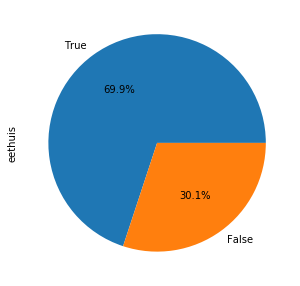

In [14]:
#there are many approaches to printing in matplotlib, working with fig, ax = plt.subplots gives a lot of flexibility
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto.eethuis.value_counts().plot(kind='pie', ax=ax, autopct="%1.1f%%")

#### How many restaurants have the tag "snack"?

In [15]:
bool_filter = "snack"
df_resto[bool_filter].value_counts()

False    665
True     223
Name: snack, dtype: int64

#### Plot the matching pie chart as before (but for snack)

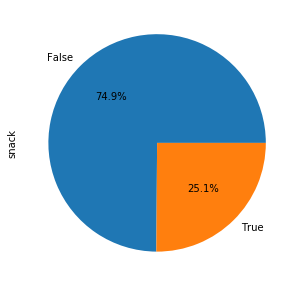

In [16]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto.snack.value_counts().plot(kind='pie', ax=ax, autopct="%1.1f%%")

#### How many restaurant have the tag "cateraar"?

In [17]:
bool_filter = "cateraar"
df_resto[bool_filter].value_counts()

False    769
True     119
Name: cateraar, dtype: int64

#### Plot the matching pie chart as before

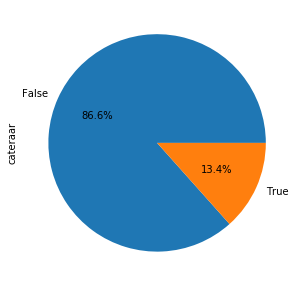

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto.cateraar.value_counts().plot(kind='pie', ax=ax, autopct="%1.1f%%")

#### How many restaurants are both "eethuis" and "cateraar"?
> HINT: You can use boolean indexes

In [19]:
len(df_resto[(df_resto.eethuis == True) & (df_resto.cateraar == True)])

44

#### How many restaurants are both "eethuis" and "snack"?

In [20]:
len(df_resto[(df_resto.eethuis == True) & (df_resto.snack == True)])

89

#### How many restaurants have the tags "eethuis", "snack" and "cateraar"?

In [21]:
len(df_resto[(df_resto.eethuis == True) & (df_resto.snack == True) & (df_resto.cateraar == True)])

10

***

#### Next, we want to know more about where these restaurants are located.

> Use the pandas [.apply()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) function to execute a function on each row of the dataframe. 

>The function will have the parameter row and using this parameter we will construct a proper address for each restaurant

> The address will then be provided to a web API located at http://loc.geopunt.be/v2/Location 
More info: http://loc.geopunt.be/Help/Api/GET-v2-Location_q_latlon_xy_capakey_poi_c

> This API will return information about the address if possible. The response also contains the latitude and longitude which we need. Add two new fields to the row for the latitude and longitude and assign the received values to it.


In [22]:
def get_coordinates(row):
    # Construct the address
    address = row['street']+" "+str(row.zipcode)+" "+row.city
    
    # Create the content of the querystring
    payload = {'q': address}
    
    # URL of the api to request
    api = "http://loc.geopunt.be/v2/Location"
    
    # Execute the request (the response will be in json)
    r = requests.get(api,params=payload)
    if r.ok:
        try:
            coordinates = r.json()['LocationResult'][0]['Location']
            row['lat'] = coordinates['Lat_WGS84']
            row['lon'] = coordinates['Lon_WGS84']
        except:
            print ("Could not be found, discarding: " + r.url)
            
    else:
        row['lat'],row['lon']=np.NaN
    return row

In [23]:
# Apply the function created above on every row of the DataFrame
df_resto = df_resto.apply(get_coordinates, axis=1)

Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=E.+Jacqmainlaan+56+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Leeuwestraat+23+2000+Antwerpen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=E.+Jacqmainlaan+7+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Sint-Amandsstraat+15+9000+Gent
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Dikstraat+3+2430+Vorst%2C+Kempen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Dorpstraat+30+9667+Sint-Maria-Horebeke
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Alfonssmetsplein+3000+Leuven
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Kapucijnestraat+44+8400+Oostende
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Borgvalstraat+11+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Louisalaan+455+1050+Elsene
Coul

Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Calle+Timanfaya+2+35510+Puerto+del+Carmen+T%C3%ADas%2C+Canarias%2C+Spain
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Breughelstraat+32+2000+Antwerpen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Foodmaker+Headoffice+Nijverheidsstraat+56+2260+Westerlo
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=J.P.+Minckelersstraat+48+3000+Leuven
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Paalstraat+2015+2900+Schoten
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Minderbroerdersrui+34+2000+Antwerpen
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Petite+Somme+5+6940+Septon+Durbuy
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Sint-Gillisplein+28+1000+Brussel
Could not be found, discarding: http://loc.geopunt.be/v2/Location?q=Verschansingsstraat+59+2000+Antwerpen
Could not be found

#### How many restaurants are still available in our DataFrame if we remove the ones without lat/lon coordinates?

In [24]:
# Filter restaurants with missing coordinates
df_resto = df_resto[(df_resto.lat != np.NaN) & (df_resto.lon != np.NaN)]

#### Next, we will plot the locations of the restaurants in a scatterplot using [matplotlib](https://matplotlib.org/). 
> Matplotlib is a plotting library in python. It contains many plotting options. 

> Use a [scatter plot](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) to plot the longitude versus latitude (i.e. x-axis = longitude)
> Label the axis, and color the points green.

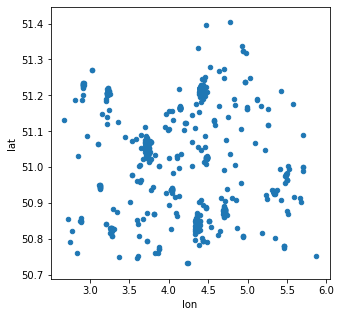

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto.plot(x='lon', y='lat', ax=ax, kind='scatter')

#### As we don't have an explicit map of Belgium in our scatterplot, it is difficult to distinguish between the different provinces and also cities. Next, we will add the provinces to our DataFrame.

> Use the pandas [.apply()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) function to execute a function on each row of the dataframe. Create a function that takes a row of data (a restaurant) and using the zipcode, adds an additional field to the row called "provincie" with the matching province value. Subsequently, return the row. To know which range of zipcodes match a certain province use this page: https://nl.wikipedia.org/wiki/Postcode 

In [26]:
#add extra field province to the row objects
def add_postcodes(row):
    try:
        zipcode = int(row['zipcode'])
        if 1000 <= zipcode <= 1299:
            row['provincie']="Brussels Hoofdstedelijk Gewest"
        elif 1300 <= zipcode <= 1499:
            row['provincie']="Waals-Brabant"
        elif (1500 <= zipcode <= 1999) or (3000 <= zipcode <= 3499):
            row['provincie']="Vlaams-Brabant"
        elif 2000 <= zipcode <= 2999:
            row['provincie']="Antwerpen"
        elif 3500 <= zipcode <= 3999:
            row['provincie']="Limburg"
        elif 4000 <= zipcode <= 4999:
            row['provincie']="Luik"
        elif 5000 <= zipcode <= 5999:
            row['provincie']="Namen"
        elif (6000 <= zipcode <= 6599) or (7000 <= zipcode <= 7999):
            row['provincie']="Henegouwen"
        elif 6600 <= zipcode <= 6999:
            row['provincie']="Luxemburg"
        elif 8000 <= zipcode <= 8999:
            row['provincie']="West-Vlaanderen"
        elif 9000 <= zipcode <= 9999:
            row['provincie']="Oost-Vlaanderen"
    except:
        print('not a valid zipcode', row['zipcode'])
        row['provincie']=""
        
    return row


> Execute the function using the .apply() function

In [27]:
df_resto = df_resto.apply(add_postcodes, axis=1)
df_resto = df_resto[df_resto.provincie != ""]

not a valid zipcode 35510 Puerto del Carmen


#### Again, plot the coordinates of the restaurants using a scatter plot. However, only plot those that are located in West-Flanders

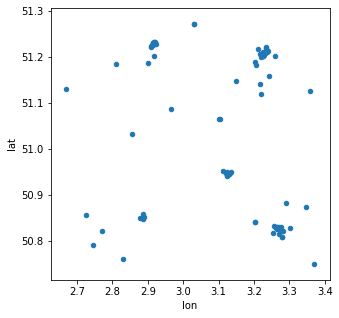

In [28]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto[df_resto.provincie=='West-Vlaanderen'].plot(x='lon', y='lat', ax=ax, kind='scatter')

#### Plot all the restaurants of flemish provinces on a scatter plot. Plot each point according to its province. I.e. West-Vlaanderen = green; Oost-Vlaanderen = Blue; ...

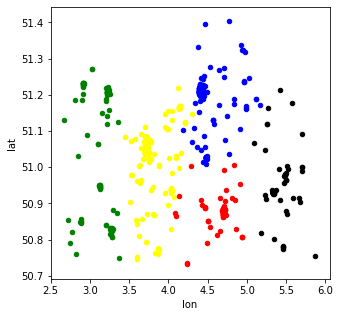

In [29]:
provs = ["West-Vlaanderen", "Oost-Vlaanderen", "Antwerpen", "Vlaams-Brabant", "Limburg"]
colors = ["green", "yellow", "blue", "red", "black"]

fig, ax = plt.subplots(1,1, figsize=(5,5))
for color,prov in zip(colors,provs):
    df_resto[df_resto.provincie==prov].plot(x='lon', y='lat', ax=ax, kind='scatter', color=color)




> In this map you should see the provinces better. However, it is difficult to see where the most restaurants are located.
> To improve this, we will use a [hexbin](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-hexbin). Pandas also provides some plotting options (it also uses matplotlib in the background). 

#### Use the hexbin plot to plot the location density. No colors have to be assigned to the respective provinces. We only want to know the density. ####

> Set the gridsize equal to 15 (gridsize = number of bins in x direction)


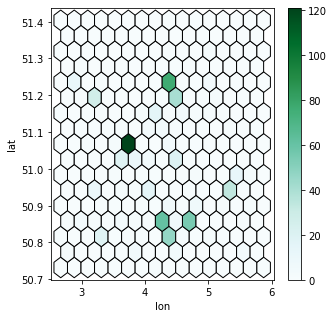

In [30]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto.plot(x='lon', y='lat', ax=ax, kind='hexbin', gridsize=15, color=color)

#### Plot a pie chart wherein every piece of the chart illustrates how many restaurants (percentage) there are in the respective provinces

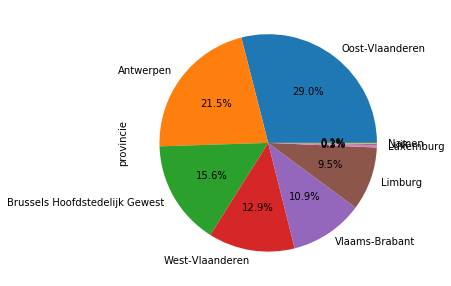

In [31]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
df_resto.provincie.value_counts().plot(kind='pie', ax=ax, autopct="%1.1f%%")

#### Which provence has the most restaurants? 
> Do not use the value you can read from the pie chart. Use the value_counts function and the idxmax function on the DataFrame

In [32]:
df_resto.provincie.value_counts().idxmax()

'Oost-Vlaanderen'

#### Create a dataframe which has for every province (province should be the index!!) the total of counts of a certain tag. For example the tag 'snack'. Antwerp has XX restaurants with tag 'snack', Limburg has YY,...

It suffices to look at 'snack', 'eethuis' and 'cateraar'

**HINT1:** have a look at groupby, and the agg({key: func}) function 

**HINT2:** as_index = False, circumvents the use of a hierarchical index

In [33]:
#+++ your code here +++
restos_agg = df_resto[['provincie','snack', 'eethuis', 'cateraar']].groupby(['provincie'], as_index=True).agg('sum')
print(restos_agg)

                                snack  eethuis  cateraar
provincie                                               
Antwerpen                        54.0    141.0      27.0
Brussels Hoofdstedelijk Gewest   25.0    106.0      12.0
Limburg                          20.0     64.0      15.0
Luik                              1.0      0.0       0.0
Luxemburg                         0.0      2.0       0.0
Namen                             0.0      0.0       0.0
Oost-Vlaanderen                  70.0    160.0      39.0
Vlaams-Brabant                   20.0     71.0      14.0
West-Vlaanderen                  33.0     76.0      12.0


#### Create a bar chart with the tag occurrence for 'West-Vlaanderen'

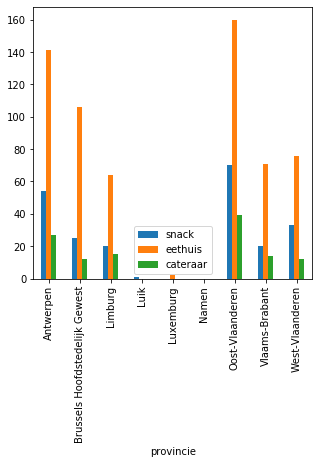

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
restos_agg.plot(kind='bar', ax=ax)

#### Create a stacked bardiagram. Each bar should correspond to a provence. Each segment in the bar should correspond to eethuis, snack or catraar. The pieces should represent how many restaurants in the respective province have the respective tag.

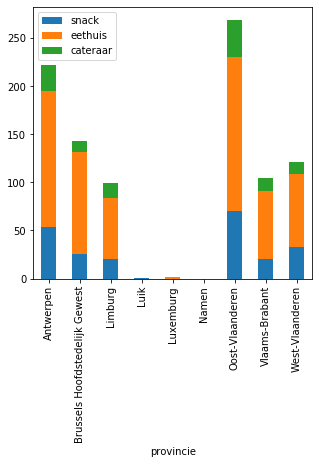

In [35]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
restos_agg.plot(kind='bar', ax=ax, stacked=True)

#### Now do the opposite: one bar per tag, and the segments correspond to #tags of this type per province

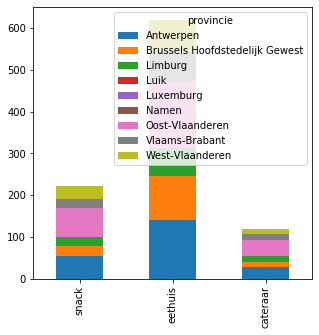

In [36]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
restos_agg.T.plot(kind='bar', ax=ax, stacked=True)

***

### Next, we will look at the other tags a restaurant can have

#### How many restaurants have the tag gastronomisch?

In [37]:
print(df_resto.gastronomisch.agg('sum'))

40


#### In which unique provinces are these restaurants located? And how many are there per province? Show this in a bar chart.

In [38]:
restos_agg = df_resto[['provincie', 'gastronomisch']].groupby(['provincie'], as_index=True).agg('sum')
print(restos_agg)

                                gastronomisch
provincie                                    
Antwerpen                                 4.0
Brussels Hoofdstedelijk Gewest            4.0
Limburg                                  11.0
Luik                                      1.0
Luxemburg                                 0.0
Namen                                     1.0
Oost-Vlaanderen                          12.0
Vlaams-Brabant                            1.0
West-Vlaanderen                           6.0


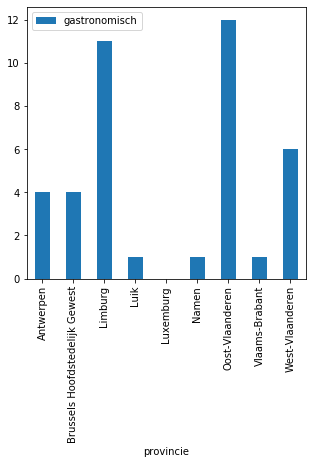

In [39]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
restos_agg.plot(kind='bar', ax=ax)

#### How many restaurants are eva-voordeel?

In [54]:
print(df_resto[['eva-voordeel']].agg('sum'))
restos_agg = df_resto[['provincie', 'eva-voordeel']].groupby(['provincie'], as_index=True).agg('sum')
print(restos_agg)

eva-voordeel    57
dtype: int64
                                eva-voordeel
provincie                                   
Antwerpen                                8.0
Brussels Hoofdstedelijk Gewest          11.0
Limburg                                  2.0
Luik                                     1.0
Luxemburg                                1.0
Namen                                    0.0
Oost-Vlaanderen                         25.0
Vlaams-Brabant                           6.0
West-Vlaanderen                          3.0


#### In which provinces are these located? (barplot)

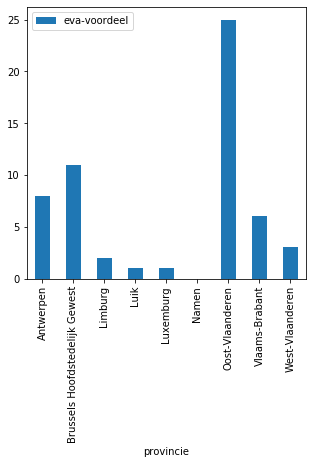

In [41]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
restos_agg.plot(kind='bar', ax=ax)

***

#### How many restaurants are there with 5 tags, how many with 4 tags, etc ... plot this as a barplot (tags are the columns with boolean values)

In [42]:
def count_tags(row):
    # Count how many tags there are in the row
    try:
        ntags=(row==True).sum()
        row['nr_of_tags']=ntags
    except:
        row['nr_of_tags']=0
        
    return row

In [43]:
# Apply the above function on the DataFrame
df_resto = df_resto.apply(count_tags, axis=1)


1    493
2    271
3     73
0     33
4     16
5      1
Name: nr_of_tags, dtype: int64


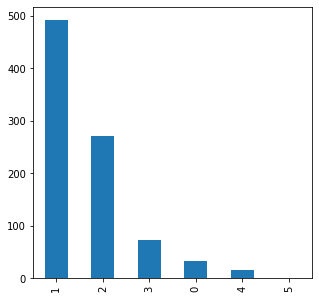

In [44]:
# Plot
restos_agg = df_resto['nr_of_tags'].value_counts()
print(restos_agg)
fig, ax = plt.subplots(1,1, figsize=(5,5))
restos_agg.plot(x='nr_of_tags', kind='bar', ax=ax)

#### Create a scatter plot of the locations of the restaurants (longitude versus latitude), where the size of the points is equal to the number of tags to the power of four.

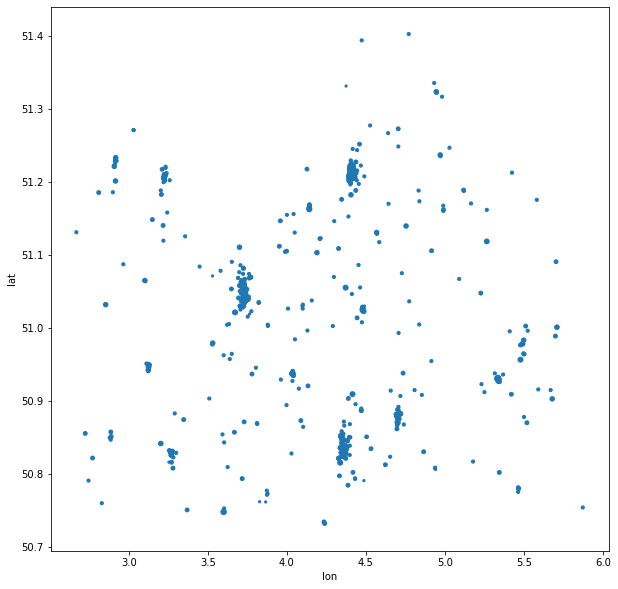

In [58]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
df_resto.plot(x='lon', y='lat', ax=ax, kind='scatter', s=(df_resto.nr_of_tags+1)*5)

#### Create a pie chart plot for each individual provence. Each pie chart should illustrate how many restaurants have how many tags (in percentage)

> HINT: create a dataframe first which counts the combination province, nr_of_tags

In [46]:
df_fractions = df_resto.groupby(['provincie', 'nr_of_tags'], as_index=True).size().reset_index(name="times").set_index('nr_of_tags')
print(df_fractions)

                                 provincie  times
nr_of_tags                                       
0                                Antwerpen      6
1                                Antwerpen    101
2                                Antwerpen     55
3                                Antwerpen     24
4                                Antwerpen      5
0           Brussels Hoofdstedelijk Gewest      6
1           Brussels Hoofdstedelijk Gewest     81
2           Brussels Hoofdstedelijk Gewest     42
3           Brussels Hoofdstedelijk Gewest      8
4           Brussels Hoofdstedelijk Gewest      1
1                                  Limburg     43
2                                  Limburg     30
3                                  Limburg      9
4                                  Limburg      2
2                                     Luik      2
0                                Luxemburg      1
1                                Luxemburg      1
2                                Luxemburg      1


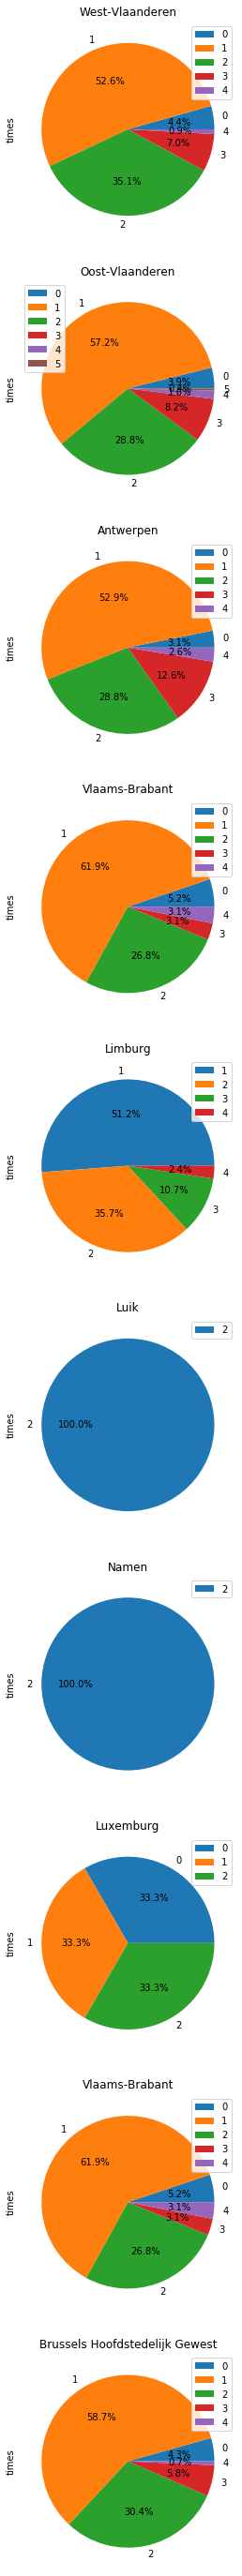

In [47]:
# Now plot
provs = ["West-Vlaanderen", "Oost-Vlaanderen", "Antwerpen", "Vlaams-Brabant", "Limburg", "Luik", "Namen", "Luxemburg", "Vlaams-Brabant", "Brussels Hoofdstedelijk Gewest"]
fig, ax = plt.subplots(10,1, figsize=(5,50))
for i,prov in enumerate(provs):
    df_fractions[df_fractions.provincie==prov].plot(y='times', kind='pie', ax=ax[i], autopct="%1.1f%%", title=prov)

In [48]:
# Congratulations you finished your first lab!!!

# Congratulations you finished your first lab!!!